<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> Next up is making the pipeline more automated. Scaling the targets. And finetune  the  LSTM, which architeture should it have. How many lags, how many LSTM units, how many  layers, how many perceptrons, which activation functions, and which special layers to add to the architecture. 
<br>
<br>
Radical change: use NIBOR in stead of interest rate, because it is update daily and can give better results.
<h4> Readying the forecast dataset </h4>
Use Ohrnstein Uhlenbeck process to find Food_index price. Use SSB/NB to find forecasts for policy rate. Find some forecasts or eventually use OU-process to find the FX.

<!-- <ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol> -->

<h1> 1. Getting started </h1>
<h2> 1.1 Importing libraries </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

import random
from keras import regularizers
import keras_tuner 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


import keras

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import RMSprop, Adam


from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from keras.callbacks import EarlyStopping


In [2]:
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)
rng = np.random.default_rng(42)

<h2> 1.2 Downloading data </h2>

In [3]:
df = pd.read_csv('Preprocessed_data.csv')
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date'], axis=1, inplace=True)

<h2> 1.3 Splitting data in 3*2 </h2>
<p> SPlitting data into train, test and validation with the following split: 70 | 15 |15.

In [4]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

<h1> 2. Feature engineering </h1>

<h2> 2.1 Manual imputing </h2>
<p>  Manually fixing NaN, and wrongful observations from the dataset in the training data. </p>

In [5]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h2> 2.2 Time dummy and Fourier  </h2>
<p> Creating a time dummy variable. Adding one new colum, where the value goes from 0 to the amount of observations. </p>

In [6]:
def det_process(X, startValue=None):
    # fourier0  =  CalendarFourier(freq='A',  order=3)
    # fourier1  =  CalendarFourier(freq='6M',  order=3)
    # fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        # seasonal=True,
        # additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    dp['trend'] += startValue
    new_X = pd.concat([X,dp], axis=1)
    return new_X
time_func = FunctionTransformer(func=det_process, 
                                kw_args={'startValue':None})


<h2> 2.3  Column specific engineering </h2>
<h3> 2.3.1 Log transformation </h3>
<p> Function for log transformation. The FOREX column shows specific characeristics from the lognormal distribution. 

In [7]:
def log_transformation(X):
    X = np.log1p(X)
    X = pd.DataFrame(X)
    return X
log_func = FunctionTransformer(func=log_transformation)

<h2> 2.4  Z-scoring </h2>
<p> Create functions for scaling the variables in a standardized way. </p>

In [8]:
zScore_func = StandardScaler()
zScoreTarget_func = StandardScaler()

<h3> 2.5 Lagged target variable

In [9]:
def lagged_target(X,y):
    for i in range(2,5,1):
        new_col = y.shift(i)
        X['tar_lag_'+str(i)] = new_col
    return X
laggedTarget_func = FunctionTransformer(func=lagged_target,
                                        kw_args={'y':None})


<h2> 2.6 Seasonal indicators </h2>
<p> Creating dummy variables for each week in a year. So creating 52 new columns, on for each week. The values are 1 if the observations falls within that week, and zero if not. </p>

In [26]:
def seasonal_indicators(X):
    weeks = np.linspace(1,52,52)
    indicator_df = pd.DataFrame()
    for i in range(0,len(weeks),1):
        column = np.where(X.index.isocalendar().week==weeks[i],1,0)
        indicator_df['IndWeek'+str(i)] = column
    indicator_df.index = X.index

    quarter = [1,2,3]
    for i in range(0,3,1):
        column = np.where(X.index.quarter==quarter[i], 1, 0)
        indicator_df['IndQuarter'+str(i)] = column
    
    indicator_df['Semiannual0'] = np.where(X.index.month <= 6, 1, 0)
    new_X = pd.concat([X, indicator_df],axis=1)
    # new_X = pd.merge(X, indicator_df, 
    #                 left_index=True, right_index=True)
    return new_X
indicator_func = FunctionTransformer(func=seasonal_indicators)



<h2> 2.5 Reshaping 2d->3d array </h2>
Function for reshaping the dataset to include timesteps, and transform the data from being 2d to 3d </p>

In [11]:
def reshaper(X, timeSteps=None):
    X = pd.DataFrame(X)
    new_Xs = [np.array(X[timeSteps:])]

    for i in range(1, timeSteps+1,1):
        shift_X  = np.array(X.shift(i))
        new_Xs.append(shift_X[timeSteps:])
    # for i in range(1,timeSteps+1,1):
    #     shift_X  = np.array(X.shift(-i))
    #     new_Xs.append(shift_X[timeSteps:])

    X_reshaped = np.stack(new_Xs, axis=1)
    print(X_reshaped.shape)
    return X_reshaped

reshape_func = FunctionTransformer(func=reshaper, kw_args={'timeSteps':None})

<h2> 2.8 Lagged variables for MM </h2>

In [12]:
def lag_MM(X):
    cols = ['FX_EURONOK','Interest_rate', 'Food_index']
    lags = [[1,2,3,4,5,6,7,8,9,10,11,12,13],
            [3,13],
            [1,2,3,4,5,6]]

    lag_df = pd.DataFrame()
    for i in range(0,3,1):
        for j in range(len(lags[i])):
            name = cols[i]+str(lags[i][j])
            lag_df[name] = X[cols[i]].shift(lags[i][j]) 
    final_df = pd.concat([X, lag_df],axis=1)
    final_df['trend_sq'] = X['trend']**2
    return final_df[13:]
MM_lag = FunctionTransformer(func=lag_MM)

<h1> 3. Multi Model, traditional </h1>

In [13]:
def grid_searcher(depth_int='', nest_int=''):

    models = []
    for i in range(0,len(depth_int),1):
        for j in range(0,len(nest_int),1):
            sel_model = RandomForestRegressor(random_state=42,
                                              max_depth=int(depth_int[i]),
                                              n_estimators=int(nest_int[j]))
            models.append(sel_model)
    return models

def timeSeriesCV(model='', train='', test='', cv=''):
    baseline = 0.5
    baselen = len(X_train)
    split = 0.5/(cv+1)

    scores = []
    for i in range(0,cv,1):
        ref_idx_train = int(baselen*((split*i)+baseline))
        ref_idx_test = int(baselen+((split*i+1)+baseline))

        sel_X_train = train.iloc[:ref_idx_train]
        sel_y_train = test.iloc[:ref_idx_train]

        sel_X_test = train.iloc[ref_idx_train: ref_idx_test]
        sel_y_test = test.iloc[ref_idx_train: ref_idx_test]

        model.fit(sel_X_train,sel_y_train)
        
        test_pred = model.predict(sel_X_test)
        scores.append(MAPE(test_pred,sel_y_test))
    
    return np.mean(scores)

#Finding best model
def best_model(depth_int, nest_int, train, test, cv):
    models =  grid_searcher(depth_int, nest_int)

    results = []
    for i in range(0,len(models),1):
        score = timeSeriesCV(model=models[i], train=train, test=test, cv=cv)
        model = models[i]
        results.append([score,model])

    low = min([results[i][0] for i in range(len(results))])
    idx = np.where([results[i][0] for i in range(len(results))]== low)

    best_model = results[int(idx[0])][1]
    return best_model

In [57]:
from sklearn.neighbors import KNeighborsRegressor

In [83]:
X_train_preprocessed_MM[:,61:-1]

InvalidIndexError: (slice(None, None, None), slice(61, -1, None))

In [93]:
def MM_time(X,y=None, fit=None):
    if fit==True:
        global model_trend 
        model_trend = LinearRegression()
        model_trend.fit(X[['const', 'trend']], y)
    y_trend = pd.Series(model_trend.predict(X[['const', 'trend']]), 
                        index=X.index)

    if fit==True:
        y_train_sea = y-y_trend
        global model_sea
        model_sea = KNeighborsRegressor(n_neighbors=10)
        model_sea.fit(X.iloc[:,5:61],y_train_sea)
    y_sea = model_sea.predict(X.iloc[:,5:61])

    if fit==True:
        y_train_cyc = y - y_trend - y_sea
        global model_cyc
        model_cyc = best_model(np.linspace(8,16,8), np.linspace(8,16,9), X.iloc[:,61:81], y_train_cyc, cv=3)
        model_cyc.fit(X.iloc[:,61:81],y_train_cyc)
    y_cyc = model_cyc.predict(X.iloc[:,61:81])

    if fit==True:
        y_train_resid = y - y_trend- y_sea - y_cyc
        global model_resid
        model_resid = best_model(np.linspace(8,16,8),  np.linspace(8,16,9), X, y_train_resid, cv=3)
        model_resid.fit(X,y_train_resid)
    y_resid = model_resid.predict(X)

    final_y  = y_trend+y_cyc+y_resid
    return final_y
MM_pred = FunctionTransformer(func=MM_time, kw_args={'y':None, 'fit':None})

<h1> 4.  Pipelining </h1>
<h2> 4.1 Column specific pipeline </h2>

In [15]:
X_forecast = pd.read_csv('forecast_df.csv')
X_forecast.index = pd.to_datetime(X_forecast['Date'], format='%Y-%m-%d')
X_forecast.drop(['Date'], axis=1, inplace=True)

In [16]:
engineering_func = ColumnTransformer(
    transformers=[
        ('loger', log_func, ['FX_EURONOK']),
    ], remainder='passthrough')

<h2> 4.2 Total pipeline </h2>

In [17]:
# target_scaler = StandardScaler()
# y_train_pre = target_scaler.fit_transform(np.array([y_train[14:]]).T)
# y_val_pre = target_scaler.transform(np.array([y_val[14:]]).T)
# y_test_pre = target_scaler.transform(np.array([y_test[14:]]).T)

y_train_pre = y_train[13:]
y_val_pre = y_val[:]
y_test_pre =y_test[:]

X_train_corr = pd.concat([X_train], axis=0)
X_val_corr = pd.concat([X_train[:13],X_val], axis=0)
X_test_corr = pd.concat([X_val[:13],X_test], axis=0)
X_forecast_corr = pd.concat([X_test[:13],X_forecast], axis=0)

In [27]:
pipe = Pipeline(steps=[
    ('det', time_func),
    ('ind', indicator_func),
    # ('lag', laggedTarget_func),
    ('Col_spec', engineering_func),
    ('zScore_func', zScore_func),
    ('res', reshape_func),
    # ('lstm', LSTM_pred)
])

pipe.set_params(
                det__kw_args={'startValue':0-13},
                # lag__kw_args={'y':y_train},
                res__kw_args={'timeSteps':13}
                )
X_train_preprocessed  = pipe.fit_transform(X_train_corr)

pipe.set_params(det__kw_args={'startValue':959-13}, 
                # lag__kw_args={'y':y_val},
                res__kw_args={'timeSteps':13}
                )
X_val_preprocessed  = pipe.transform(X_val_corr)

pipe.set_params(det__kw_args={'startValue':1079-13}, 
                # lag__kw_args={'y': y_test},
                res__kw_args={'timeSteps':13}
                )
X_test_preprocessed  = pipe.transform(X_test_corr)


pipe.set_params(det__kw_args={'startValue':1200-13}, 
                # lag__kw_args={'y': y_test},
                res__kw_args={'timeSteps':13}
                )
X_fore_preprocessed  = pipe.transform(X_forecast_corr)

(947, 14, 61)
(120, 14, 61)
(120, 14, 61)
(52, 14, 61)


In [28]:
X_train_corr = pd.concat([X_train], axis=0)
X_val_corr = pd.concat([X_train[:13],X_val], axis=0)
X_test_corr = pd.concat([X_val[:13],X_test], axis=0)
X_forecast_corr = pd.concat([X_test[:13],X_forecast], axis=0)

In [94]:
pipe_MM = Pipeline(steps=[
        ('det', time_func),
        ('ind', indicator_func),
        ('lag', MM_lag),
        ('model', MM_pred)
])


pipe_MM.set_params(det__kw_args={'startValue':0},
                    model__kw_args={'y':y_train_pre,
                                    'fit':True}
                    )
X_train_preprocessed_MM  = pipe_MM.fit_transform(X_train_corr)

pipe_MM.set_params(det__kw_args={'startValue':959},
                    model__kw_args={'fit':False}
                    )
X_val_preprocessed_MM  = pipe_MM.transform(X_val_corr)

pipe_MM.set_params(det__kw_args={'startValue':1079},
                model__kw_args={'fit':False}
)
X_test_preprocessed_MM  = pipe_MM.transform(X_test_corr)

pipe_MM.set_params(det__kw_args={'startValue':1199},
                model__kw_args={'fit':False}
)
X_fore_preprocessed_MM = pipe_MM.transform(X_forecast_corr)

C:\Users\Jakob\AppData\Local\Temp\ipykernel_43284\3533995552.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_model = results[int(idx[0])][1]
C:\Users\Jakob\AppData\Local\Temp\ipykernel_43284\3533995552.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_model = results[int(idx[0])][1]


In [86]:
# X_train_preprocessed_MM.iloc[:,61:81]

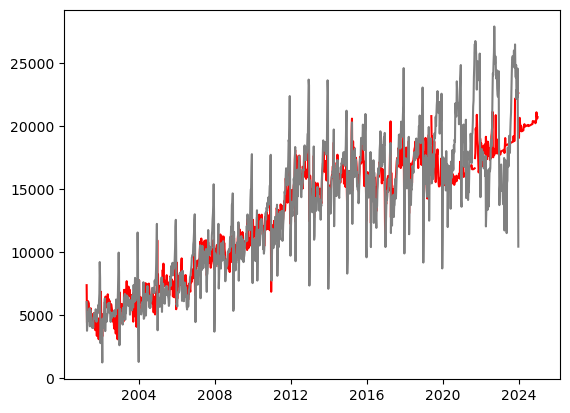

In [87]:
fig, ax = plt.subplots()
ax.plot(X_train_preprocessed_MM, color='red')
ax.plot(X_val_preprocessed_MM, color='red')
ax.plot(X_test_preprocessed_MM, color='red')
ax.plot(X_fore_preprocessed_MM, color='red')

ax.plot(y_train_pre, color='grey')
ax.plot(y_val_pre, color='grey')
ax.plot(y_test_pre, color='grey')

<h1> X. Rest are drafts.. </h1>
<h2> x1  CV_function </h2>

In [22]:
# def rolling_window_cross_val(model, metric):
#     X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
#     y = np.concatenate((y_train_pre,y_val_pre),axis=0)


#     scores = []
#     for i in range(0,3,1):
#         sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
#         sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

#         sel_X_test = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
#         sel_y_test = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
    
#         model.fit(sel_X,sel_y,
#                 epochs=500, batch_size=60,
#                 validation_data=[sel_X_test, sel_y_test],
#                 callbacks=early_stopping, verbose=False)        
#         pred = model.predict(sel_X_test)
#         score = metric(pred, sel_y_test)
#         scores.append(score)
    
#     return [np.mean(scores),model]

# cv_result = rolling_window_cross_val(model,  MAE)


In [23]:
# def ensemble_model_generator(model):
#     X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
#     y = np.concatenate((y_train_pre,y_val_pre),axis=0)


#     models = []
#     for i in range(0,3,1):
#         sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
#         sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

#         sel_X_val = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
#         sel_y_val = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
#         new_model = model
#         new_model.fit(sel_X,pd.Series(sel_y),
#                 epochs=500, batch_size=60,
#                 validation_data=[sel_X_val, pd.Series(sel_y_val)],
#                 callbacks=tuner_callback, 
#                 verbose=True)        
#         models.append(new_model)
#     models.append(model)
#     return models

# cv_result = ensemble_model_generator(model)

# def ensemble(models,X):
#     predictions = []
#     for i in range(0,len(models),1):
#         pred_sel = models[i].predict(X)
#         predictions.append(pred_sel)
#     output = np.sum(predictions,axis=0)/len(models)
#     return output


<h1> x2 Large tuner

In [88]:
def build_model(hp):
    model = tf.keras.Sequential([
        layers.Input(shape=(14,61), name='input_layer'),
        layers.LSTM(
            units = hp.Int(name='hp1', min_value=20, max_value= 150, step=15),
            return_sequences=True),
        layers.LSTM(
            units = hp.Int(name='hp2', min_value=20, max_value= 150, step=15)),

        layers.Dense(units = hp.Int(name='hp3', min_value=50, max_value= 950, step=90),
                      activation=hp.Choice("activation1", ["relu", "gelu"])
                      ),

        layers.BatchNormalization(),

        layers.Dropout(hp.Float(name='hp4',min_value=0.1, max_value=0.5, step=0.1)),

        layers.Dense(units = hp.Int(name='hp5', min_value=50, max_value= 950, step=9),
                      activation=hp.Choice('activation2', ["relu", "selu"])
                      ),

        layers.Dropout(hp.Float(name='hp7',min_value=0.0, max_value=0.45, step=0.15)),

        layers.Dense(units = hp.Int(name='hp8', min_value=50, max_value= 950, step=90),
                      activation=hp.Choice('activation3', ["selu","gelu"])
                    ),

        layers.Dropout(hp.Float(name='hp10',min_value=0.0, max_value=0.45, step=0.15)),

        layers.BatchNormalization(),

        layers.Dense(units = hp.Int(name='hp11', min_value=50, max_value= 2000, step=90),
                      activation=hp.Choice('activation4', ["silu", "selu"])),

        layers.BatchNormalization(),

        layers.Dropout(hp.Float(name='hp12',min_value=0.0, max_value=0.45, step=0.15)),

        layers.Dense(units = hp.Int(name='hp13', min_value=50, max_value= 950, step=9),
                      activation=hp.Choice('activation5', ["relu", "gelu"])),

        layers.Dense(units = hp.Int(name='hp14', min_value=50, max_value= 950, step=90),
                       activation=hp.Choice('activation6', ["relu"])),

        layers.Dense(1)
    ])

    optimizer = RMSprop(learning_rate=hp.Float(name='lr', min_value=0.0005, max_value=0.02, step=0.001))

    model.compile(optimizer=optimizer, 
                  loss = 'mae')
    return model

In [31]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='first',
    project_name='lag_08_dummy_var_trap'
)

tuner_callback=EarlyStopping(monitor='val_loss',
                            min_delta=0.001, 
                            patience=40,
                            restore_best_weights=True)

tuner.search(X_train_preprocessed, y_train_pre,
             epochs=120, batch_size=50,
             validation_data=(X_val_preprocessed,y_val_pre),
             callbacks=[tuner_callback])

Trial 10 Complete [00h 00m 35s]
val_loss: 1546.2698974609375

Best val_loss So Far: 1373.0906982421875
Total elapsed time: 00h 09m 18s


In [32]:
tuner.results_summary()

Results summary
Results in first\lag_08_dummy_var_trap
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
hp1: 125
hp2: 80
hp3: 500
activation1: relu
hp4: 0.30000000000000004
hp5: 365
activation2: selu
hp7: 0.3
hp8: 140
activation3: gelu
hp10: 0.15
hp11: 680
activation4: selu
hp12: 0.3
hp13: 140
activation5: relu
hp14: 500
activation6: relu
lr: 0.0005
Score: 1373.0906982421875

Trial 02 summary
Hyperparameters:
hp1: 110
hp2: 50
hp3: 410
activation1: relu
hp4: 0.5
hp5: 770
activation2: selu
hp7: 0.15
hp8: 50
activation3: selu
hp10: 0.44999999999999996
hp11: 680
activation4: silu
hp12: 0.44999999999999996
hp13: 734
activation5: relu
hp14: 50
activation6: relu
lr: 0.0165
Score: 1405.3494873046875

Trial 01 summary
Hyperparameters:
hp1: 35
hp2: 80
hp3: 140
activation1: relu
hp4: 0.4
hp5: 239
activation2: relu
hp7: 0.0
hp8: 500
activation3: gelu
hp10: 0.44999999999999996
hp11: 1400
activation4: silu
hp12: 0.44999999999999996
hp13: 797
activ

<h2> Actual lstm model

In [34]:
model = tf.keras.Sequential([
    layers.Input(shape=(14,61), name='input_layer'),
    layers.LSTM(units=125 ,return_sequences=True),
    layers.LSTM(units=80),
    layers.Dense(units=500 ,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=365,activation='selu'),
    layers.Dropout(0.3),
    layers.Dense(units=140,activation='gelu'),
    layers.Dropout(0.15),
    layers.BatchNormalization(),
    layers.Dense(units=680 ,activation='selu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=140,activation='relu'),
    layers.Dense(units=500,activation='relu'),
    layers.Dense(1)
    ])

optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer,
            loss = 'mae')
tuner_callback=EarlyStopping(monitor='val_loss',
                            min_delta=0.001, 
                            patience=50,
                            restore_best_weights=True)
history = model.fit(X_train_preprocessed, y_train_pre,
            epochs=200, batch_size=50,
            validation_data=(X_val_preprocessed,y_val_pre),
            callbacks=[tuner_callback])

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 11588.1094 - val_loss: 18361.6270
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 11227.0088 - val_loss: 17896.4121
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 10404.2227 - val_loss: 16914.5195
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9121.8350 - val_loss: 15470.1855
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7416.7354 - val_loss: 13910.4697
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5635.1289 - val_loss: 12123.7783
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3700.6475 - val_loss: 9787.8330
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2425.0215 - val_loss: 9135.0459
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2478.8948 - val_loss: 8484.5000
Epoch 10/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2254.8789 - val_loss: 7471.4150
Epoch 11/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2319.5571

(0.0, 5000.0)

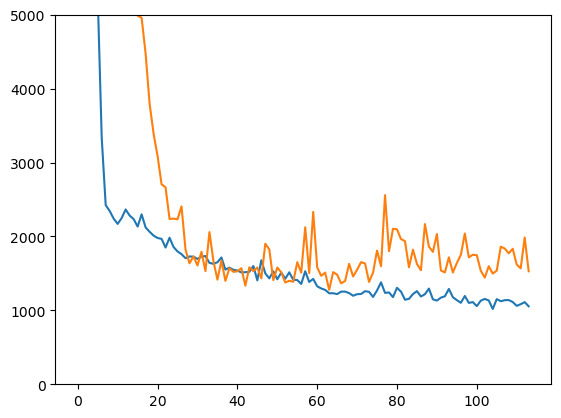

In [35]:
fox = pd.DataFrame(history.history)
fox['loss'].plot()
fox['val_loss'].plot()
plt.ylim(0,5000)

<h1> Large  tuner end

In [36]:
# model.fit(X_train_preprocessed, y_train_pre)
train_pred = model.predict(X_train_preprocessed)
val_pred = model.predict(X_val_preprocessed)
test_pred = model.predict(X_test_preprocessed)
forecast = model.predict(X_fore_preprocessed)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


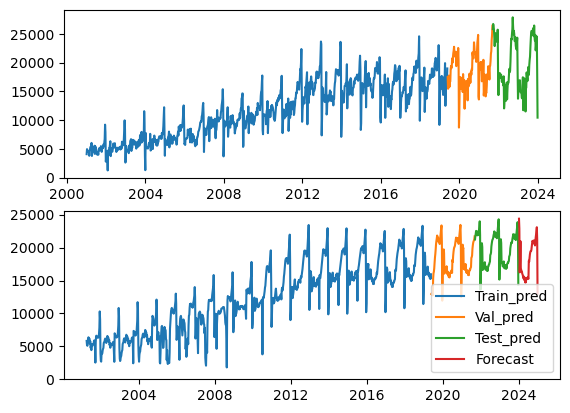

In [89]:
fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')
ax[0].set_ylim(0,)

ax[1].plot(X_train.index[13:], train_pred, label='Train_pred')
ax[1].plot(X_val.index[:], val_pred, label='Val_pred')
ax[1].plot(X_test.index[:], test_pred, label='Test_pred')
ax[1].plot(X_forecast.index[:], forecast, label='Forecast')
ax[1].set_ylim(0,)

plt.legend()
plt.show()

In [90]:
from sklearn.metrics import mean_absolute_error as MAE
def ME(true, pred):
    answer = sum(np.array(true)-np.array(pred).flatten())
    return round(answer,3)
from sklearn.metrics import mean_squared_error as MSE

In [91]:
# metric_report

actual = [y_train_pre, y_val_pre, y_test_pre]
lstm = [train_pred,  val_pred, test_pred, forecast]
mm = [X_train_preprocessed_MM, X_val_preprocessed_MM, X_test_preprocessed_MM, X_fore_preprocessed_MM]

ME_val = [ME(actual[1], lstm[1]),ME(actual[1], mm[1])]
ME_test= [ME(actual[2], lstm[2]), ME(actual[2], mm[2])]

MAE_val = [MAE(actual[1], lstm[1]), MAE(actual[1], mm[1])]
MAE_test = [MAE(actual[2], lstm[2]), MAE(actual[2], mm[2])]

MSE_val = [MSE(actual[1], lstm[1]), MSE(actual[1], mm[1])]
MSE_test = [MSE(actual[2], lstm[2]), MSE(actual[2], mm[2])]


my_lstm = np.mean(val_pred.flatten() - y_val_pre)
my_mm = np.mean(val_pred.flatten() - y_val_pre)
std_lstm = np.std(val_pred.flatten() - y_val_pre)
std_mm = np.std(X_val_preprocessed_MM - y_val_pre)

In [92]:
all = [np.round(ME_val),np.round(ME_test), 
       np.round(MAE_val), np.round(MAE_test), 
       np.round(MSE_val), np.round(MSE_test),
       [np.round([my_lstm+1.28*std_lstm,my_lstm-1.28*std_lstm]),
        np.round([my_mm+1.28*std_mm,my_mm-1.28*std_mm])]
       ]
pd.DataFrame(all, 
             columns=['LSTM', 'Multi-model'],
             index=['ME_val', 'ME_test', 'MAE_val', 'MAE_test', 'MSE_val', 'MSE_test', 'CI']
            )

,LSTM,Multi-model
ME_val,12630.0,252943.0
ME_test,-2903.0,130369.0
MAE_val,1275.0,3029.0
MAE_test,2200.0,3630.0
MSE_val,2985049.0,14372517.0
MSE_test,6942548.0,20105066.0
CI,"[2102.0, -2313.0]","[3928.0, -4139.0]"


<h2> Residual analysis

In [41]:
def confidence_interval(predictions, simulations, two_sided_CI):
    std = np.std(val_pred.flatten() - y_val_pre)#/np.sqrt(len(val_pred.flatten()))

    all_sim = []
    for i in range(0,simulations,1):
        sim = []
        for j in range(0,len(predictions),1):
            sel = predictions[j][0] + rng.normal() * std + sum([rng.normal() * std for i in range(j)])
            sim.append(sel)
        all_sim.append(sim)

    crit_val = (100-two_sided_CI)/2
    sums = [[all_sim[i][j] for i in range(simulations)] for j in range(len(predictions))]
    low_list = [np.percentile(sums[i],crit_val) for i in range(len(predictions))]
    high_list = [np.percentile(sums[i],100-crit_val) for i in range(len(predictions))]

    return [low_list, high_list]

In [42]:
CI_val = confidence_interval(val_pred, 10000, 40)
CI_test = confidence_interval(test_pred, 10000, 80)
CI_forecast = confidence_interval(forecast, 10000, 80)

<function matplotlib.pyplot.show(close=None, block=None)>

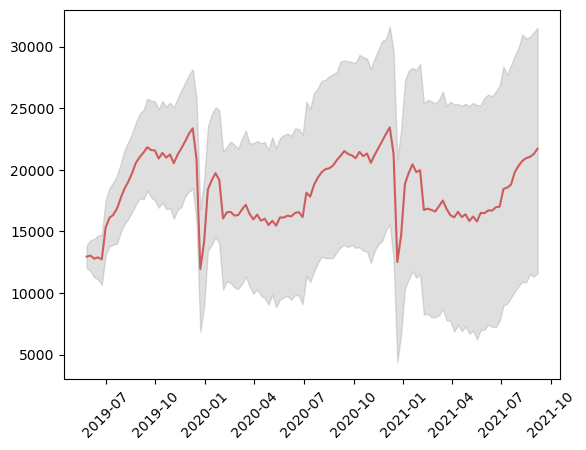

In [43]:
fig, ax = plt.subplots()
ax.plot(y_val_pre.index, val_pred, color='indianred')
ax.fill_between(y_val_pre.index, CI_val[0], CI_val[1], color='grey', alpha=.25)
plt.xticks(rotation=45)
plt.show

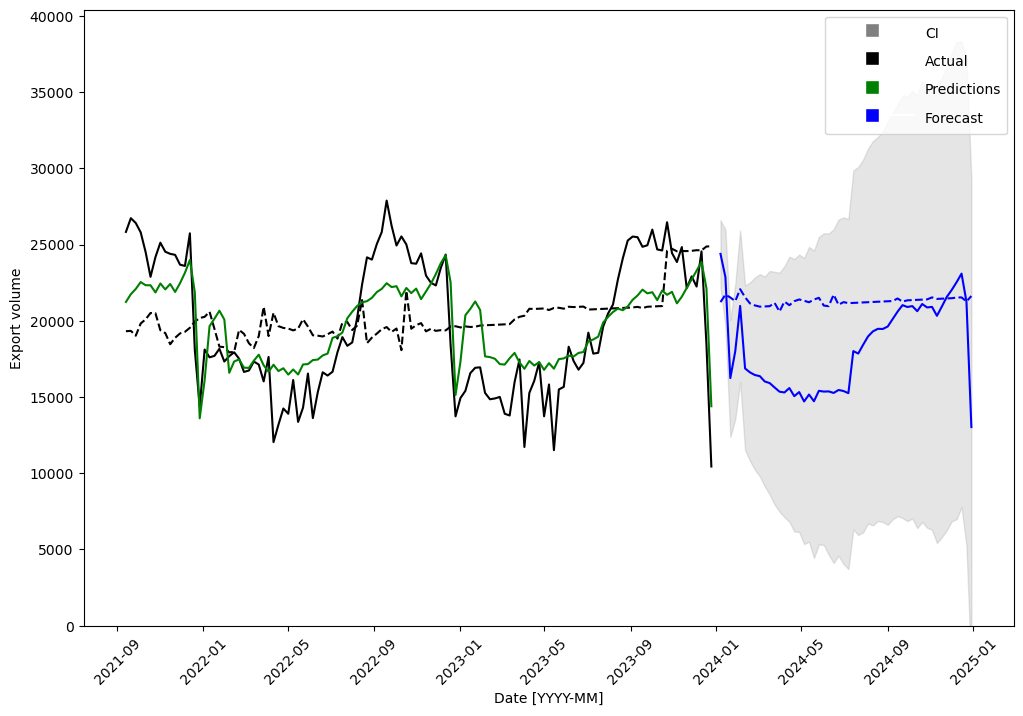

In [95]:
idx = [X_train.index[13:], X_val.index, X_test.index, X_forecast.index]
actual = [y_train_pre, y_val_pre, y_test_pre]
pred = [train_pred, val_pred, test_pred, forecast]
ConfI = [CI_val, CI_test, CI_forecast]


fig,ax = plt.subplots(figsize=(12,8))
ax.plot(idx[2], actual[2], color='black')
ax.plot(idx[2], X_test_preprocessed_MM, color='black', linestyle='--')
ax.plot(idx[2], pred[2], color='green')
ax.plot(idx[3], pred[3], color='blue')
ax.plot(idx[3], X_fore_preprocessed_MM, color='blue', linestyle='--')


ax.fill_between(idx[3], ConfI[2][0], ConfI[2][1], color='grey', alpha=.2)

legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', label='CI', markerfacecolor='grey', markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='Actual', markerfacecolor='black', markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='Predictions', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='s', color='w', label='Forecast', markerfacecolor='blue', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper right',handlelength=6, handleheight=2)
plt.xlabel('Date [YYYY-MM]')
plt.ylabel('Export volume')
plt.xticks(rotation=45)
plt.ylim(0,)
# plt.grid()

plt.show()